In [1]:
# Import modules:
import sys
import gmsh
import matplotlib.pyplot as plt
import numpy as np

# Initialize gmsh:
gmsh.initialize()
factory = gmsh.model.occ

In [2]:
# parameters of 3d geometry
h = 10.0
x_slope = 35  # 15, 35, 60
x_top = 85
x_down = 30
x_cover = 5
z_layer0 = 20
z_layer1 = 10
z_layer2 = 30
z_sum = z_layer0 + z_layer1 + z_layer2
slope_half_width = 50
turning_corner = 270  # 90, 120, 135, 150, 270, 240, 225, 210
concave = False
angle = (360-turning_corner)/2/180*np.pi
if turning_corner < 180:
    concave = True
    angle = turning_corner/2/180*np.pi
y_half = slope_half_width * np.sin(angle)
y_sum = 2*y_half
x_cutout = slope_half_width * np.cos(angle)
x_sum = x_top + x_slope + x_cutout + x_cover + x_down  # discrepancy in the paper, x_cutout added

In [3]:
def box_from_coordinates(coordinates):
    points = []
    for i in range(8):
        points.append(factory.add_point(*coordinates[i]))
    lines = []
    for i in range(4):
        lines.append(factory.add_line(points[i], points[(i+1) % 4]))
    for i in range(4):
        lines.append(factory.add_line(points[i+4], points[(i+1) % 4+4]))
    for i in range(4):
        lines.append(factory.add_line(points[i], points[i+4]))
    surfaces = []
    loops = [[0,1,2,3],[4,5,6,7],[0,8,4,9],[1,9,5,10],[2,10,6,11],[3,11,7,8]]
    for loop in loops:
        line_tags = [lines[i] for i in loop]
        loop = factory.add_curve_loop(line_tags)
        surfaces.append(factory.add_plane_surface([loop]))
    surface_loop = factory.add_surface_loop(surfaces)
    return factory.add_volume([surface_loop])

In [4]:
# bottom layer (general foundation):
factory.add_box(0, 0, 0, x_sum, y_sum, z_layer0)

# middle layer (relatively weak foundation):
factory.add_box(0, 0, z_layer0, x_sum, y_sum, z_layer1)

# top layer (general slope mass):
top_layer = factory.add_box(0, 0, z_layer0+z_layer1, x_sum, y_sum, z_layer2)

# prepare deformed box to cut out from the top layer (left side):
coordinates_cutout_left = [[x_sum - x_down - x_cover, 0, z_layer0+z_layer1], [x_sum, 0, z_layer0+z_layer1],
                           [x_sum, y_half, z_layer0+z_layer1], [x_sum - x_down - x_cover - x_cutout, y_half, z_layer0+z_layer1],
                           [x_top + x_cutout, 0, z_sum], [x_sum, 0, z_sum],
                           [x_sum, y_half, z_sum], [x_top, y_half, z_sum]]
cutout_left = box_from_coordinates(coordinates_cutout_left)

# right side
cutout_right_with_tag = factory.copy([(3, cutout_left)])
factory.mirror(cutout_right_with_tag, 0, 1, 0, -y_half)

# left side of slope cover:
coordinates_cover_left = [[x_sum - x_down - x_cover, 0, z_layer0+z_layer1], [x_sum - x_down, 0, z_layer0+z_layer1],
                          [x_sum - x_down - x_cutout, y_half, z_layer0+z_layer1], [x_sum - x_down - x_cover - x_cutout, y_half, z_layer0+z_layer1],
                          [x_top + x_cutout, 0, z_sum], [x_top + x_cutout + x_cover, 0, z_sum],
                          [x_top + x_cover, y_half, z_sum], [x_top, y_half, z_sum]]
cover_left = box_from_coordinates(coordinates_cover_left)

# right side:
cover_right_with_tag = factory.copy([(3, cover_left)])
factory.mirror(cover_right_with_tag, 0, 1, 0, -y_half)

if concave:  # swap left and right side
    factory.translate([(3, cutout_left)], 0, y_half, 0)
    factory.translate(cutout_right_with_tag, 0, -y_half, 0)
    factory.translate([(3, cover_left)], 0, y_half, 0)
    factory.translate(cover_right_with_tag, 0, -y_half, 0)

# sut out prepared deformed boxes:
factory.cut([(3, top_layer)], [(3, cutout_left)]+cutout_right_with_tag)

# Synchronize and generate mesh:
factory.remove_all_duplicates()
factory.synchronize()
gmsh.model.mesh.setSize(gmsh.model.getEntities(0), h)
gmsh.model.mesh.generate()
gmsh.model.mesh.remove_duplicate_nodes()
gmsh.model.mesh.remove_duplicate_elements()

# Write mesh data to file:
# gmsh.write("GFG.msh")

# Create graphical user interface
# if 'close' not in sys.argv:
#     gmsh.fltk.run()

# Get node coordinates:
nodeTags, nodeCoords, nodeParams = gmsh.model.mesh.getNodes()

# Get (triangular) faces:
faceTypes, faceTags, faceNodeTags = gmsh.model.mesh.getElements(dim=2)

# Get (tetrahedral) elements:
elemTypes, elemTags, elemNodeTags = gmsh.model.mesh.getElements(dim=3)

# Extract X-, Y-, and Z- coordinates of all nodes from GMSH outputs:
node = np.array(nodeCoords)
node_X = node[0::3]
node_Y = node[1::3]
node_Z = node[2::3]

# All (tetrahedral) elements:
elem = elemNodeTags[0].reshape(-1, 4)
elem = elem-1  # indexing from 0

# All (triangular) faces on the boundary (including subdomains):
face = faceNodeTags[0].reshape(-1, 3)
face = face-1  # indexing from 0

# Subdomain tags for each element:
n_elem = elem.shape[0]
min_elemTag = min(elemTags[0])
material = np.zeros((n_elem,), dtype=int)
for i in range(3):
    _, tags, _ = gmsh.model.mesh.getElements(dim=3, tag=i+1)
    material[tags[0]-min_elemTag] = i+1

# Finalize the Gmsh API
gmsh.finalize()

Info    : Meshing 1D...                                                                                                                 
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [

Text(0.5, 0.92, 'All faces on the boundary (including subdomains)')

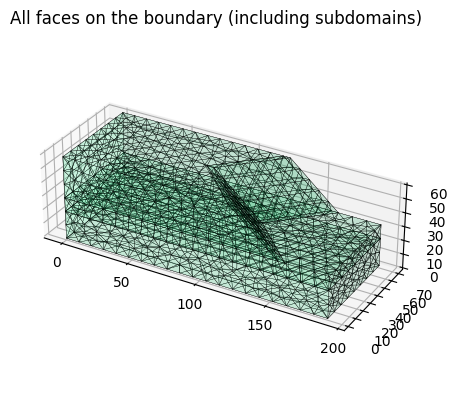

In [5]:
import matplotlib.pyplot as plt

ax = plt.axes(projection='3d')
ax.plot_trisurf(node_X, node_Y, node_Z, triangles=face, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.1])
ax.set_aspect('equal')
ax.set_title("All faces on the boundary (including subdomains)")

Text(0.5, 0.92, 'All elements')

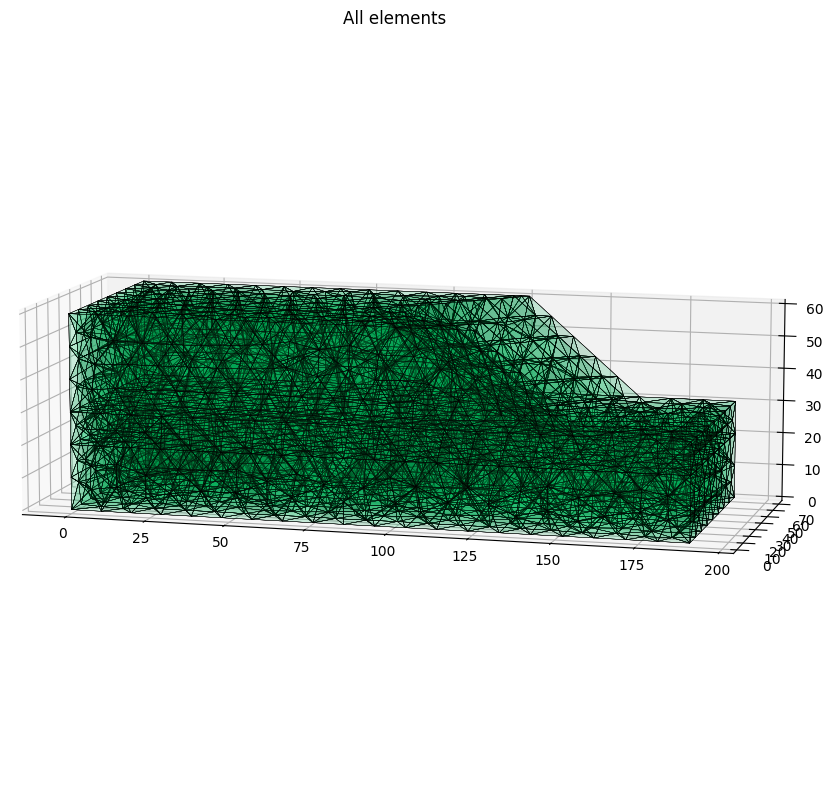

In [6]:
plt.figure(figsize=(30, 10))
ax = plt.axes(projection='3d')
# chnage viewing angle:
ax.view_init(10, -75)
for i in range(4):
    triangles = np.delete(elem, i, axis=1)
    ax.plot_trisurf(node_X, node_Y, node_Z, triangles=triangles, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.05])
ax.plot_trisurf(node_X, node_Y, node_Z, triangles=face, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.05])
ax.set_aspect('equal')
ax.set_title("All elements")

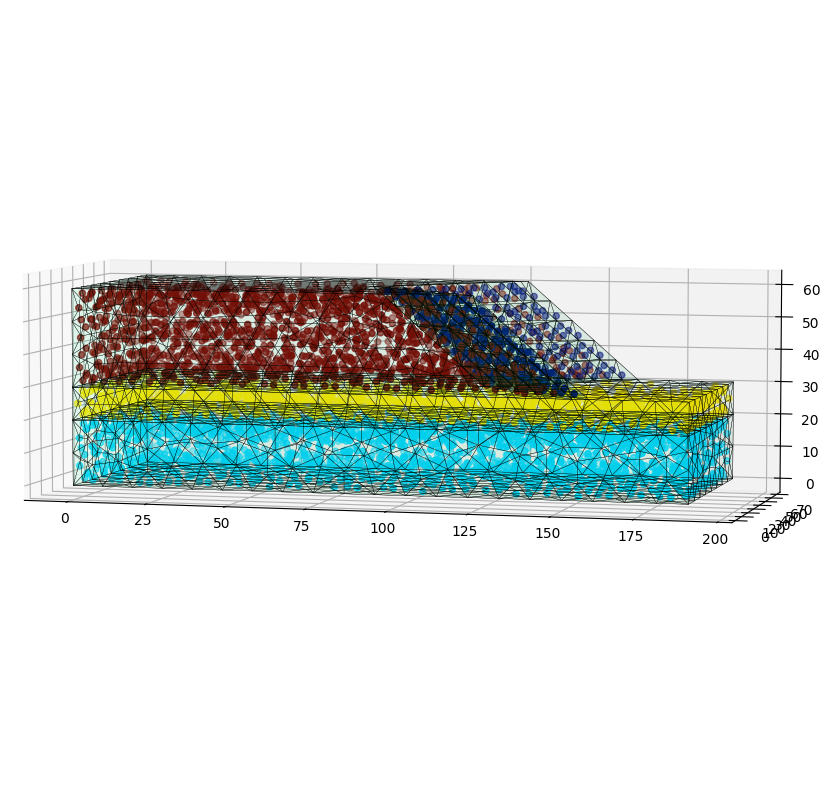

In [7]:
# show 3d scatter plot of material in each element, distinguish the material value by color:
plt.figure(figsize=(30, 10))
ax = plt.axes(projection='3d')
ax.view_init(5, -75)
center_X = np.mean(node_X[elem],axis=1)
center_Y = np.mean(node_Y[elem],axis=1)
center_Z = np.mean(node_Z[elem],axis=1)
ax.scatter(center_X, center_Y, center_Z, c=material, cmap='jet')
ax.plot_trisurf(node_X, node_Y, node_Z, triangles=face, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.05])
ax.set_aspect('equal')
plt.show()

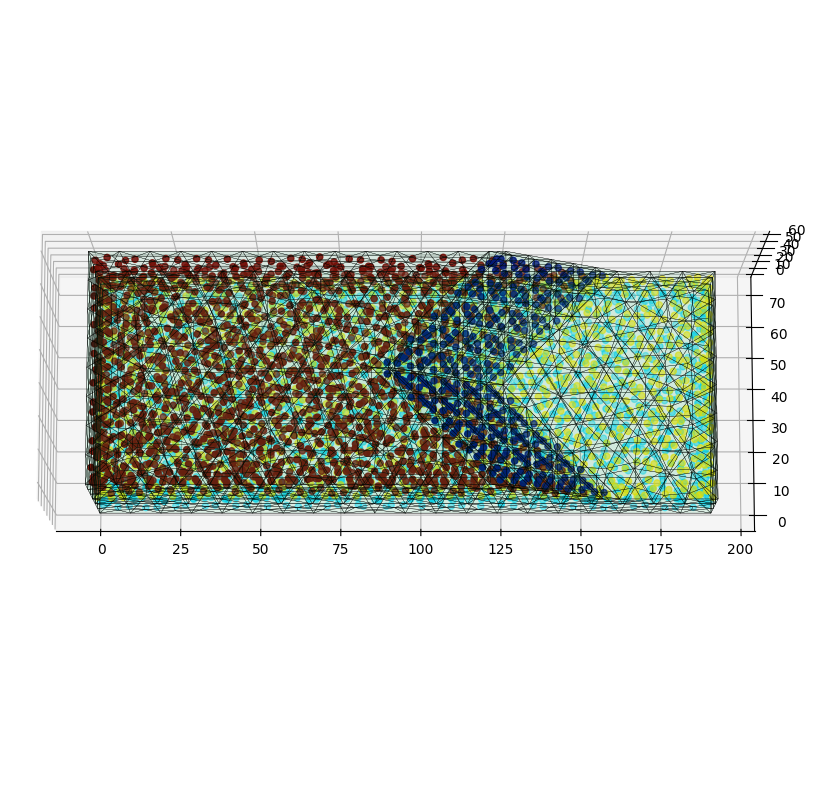

In [8]:
# the same, top view
plt.figure(figsize=(30, 10))
ax = plt.axes(projection='3d')
ax.view_init(80, -90)
ax.scatter(center_X, center_Y, center_Z, c=material, cmap='jet')
ax.plot_trisurf(node_X, node_Y, node_Z, triangles=face, linewidths=0.2, edgecolor='k', color=[0, 1.0, 0.5, 0.05])
ax.set_aspect('equal')
plt.show()